# LG
# Day4 Lab : Deep learning applied to audio II (CNN, RNN)

# External Example : Source Separation

*   Data preparation
*   Preprocessing
*   Make trainset
*   Make evalset
*   Make data loader
*   Mask-based deep learning models
*   Train
*   Test
*   Evaluation


In [1]:
# train data download

!wget --no-check-certificate -qq -r 'https://docs.google.com/uc?export=download&id=1IrdO3weEzG2qvOtPx9Q-rXLYqPivaFyE' -O data.zip

!unzip -qq /content/data.zip -d ./


# analyze data download
!wget --no-check-certificate -qq -r 'https://docs.google.com/uc?export=download&id=1LdnMCjIYb_HKooGzMqwqVyAwT_AXsFoX' -O snr_analyze.zip

!unzip -qq /content/snr_analyze.zip -d ./ 


# samples data download

!wget --no-check-certificate -qq -r 'https://docs.google.com/uc?export=download&id=1d4MjrwCASzxAr6lsHkgdNHewgsJgE4u8' -O samples.zip

!unzip -qq /content/samples.zip -d ./ 

warning [/content/data.zip]:  402862 extra bytes at beginning or within zipfile
  (attempting to process anyway)
warning [/content/snr_analyze.zip]:  402856 extra bytes at beginning or within zipfile
  (attempting to process anyway)


# **Preprocessing**

*   RMS normalization
*   Source-to-noise ratio (SNR) adjustment

Source separation을 위한 데이터를 만들기 위해서는 다양한 SNR의 비율을 가진 Mixture sample들을 만드는 것이 중요합니다.

어떻게 SNR을 조절할 수 있는지 알아보도록 하겠습니다.

In [0]:
def cal_rms(amp):
    return np.sqrt(np.mean(np.square(amp), axis=-1))

def rms_normalize(wav, ref_dB=-23.0, print_gain=False):
    # RMS normalize
    eps = np.finfo(np.float32).eps
    rms = cal_rms(wav)
    ref_linear = np.power(10, ref_dB/20.)
    gain = ref_linear / (rms + eps)
    wav = gain * wav
    if print_gain == True:
      print(gain)
    return wav

def adjust_noise(noise, source, snr):
    eps = np.finfo(np.float32).eps
    noise_rms = cal_rms(noise) # noise rms

    num = cal_rms(source) # source rms
    den = np.power(10., snr/20)
    desired_noise_rms = num/den

    # calculate gain
    try:
        gain = desired_noise_rms / (noise_rms + eps)
    except OverflowError as error:
        gain = 1.
    
    noise = gain*noise

    mix = source + noise
        
    return mix, source, noise

def random_select(wav, sample_len):
    wav_len = len(wav)
    if wav_len > sample_len:
        max_start = wav_len - sample_len
        start = random.randint(0, max_start)
        end = start + sample_len
        wav = wav[start:end]
    elif wav_len < sample_len:
        l_pad = (sample_len - wav_len)//2
        r_pad = sample_len - wav_len - l_pad
        pad = (l_pad,r_pad)
        wav = np.pad(wav, pad, 'constant')
    else:
        pass
    
    assert len(wav) == sample_len

    return wav

RMS normalization의 reference dB를 다르게 함에 따른 소리의 변화를 들어보겠습니다.

In [3]:
# Make test dirs
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

sr = 16000

speech_path = './samples/speech.wav'
speech, _ = librosa.load(speech_path, sr=16000)

speech1 = rms_normalize(speech, ref_dB=-50.0, print_gain=True)
speech2 = rms_normalize(speech, ref_dB=-5.0, print_gain=True)

0.10831415367800715
19.261282930139174


In [4]:
speech1[-1] = 1 # to prevent normalization in ipd.Audio...
ipd.Audio(speech1, rate=sr, autoplay=False)

In [5]:
speech2[-1] = 1 # to prevent normalization in ipd.Audio...
ipd.Audio(speech2, rate=sr, autoplay=False)

이제 noise를 load하여 다양한 SNR비율의 Mixture를 만들도록 하겠습니다.

adjust_noise()함수는 SNR에 따른 gain을 *noise에 곱하여* mixture와 source, noise를 반환합니다.

In [6]:
import tensorflow as tf
import numpy as np
import librosa
import glob
import os
import random
import matplotlib
import librosa.display
import IPython.display as ipd
from matplotlib import pyplot as plt


speech = rms_normalize(speech, ref_dB=-23.0, print_gain=False)

noise_path = './samples/noise.wav'
noise, _ = librosa.load(noise_path, sr=16000)
cropped_noise = random_select(noise, sample_len=len(speech))

In [7]:
mixture1, speech1, noise1 = adjust_noise(cropped_noise, speech, snr=10.)
mixture1[-1] = 1 # to prevent normalization in ipd.Audio...
ipd.Audio(mixture1, rate=sr, autoplay=False)

In [8]:
mixture2, speech2, noise2 = adjust_noise(cropped_noise, speech, snr=-10.)
mixture2[-1] = 1 # to prevent normalization in ipd.Audio...
ipd.Audio(mixture2, rate=sr, autoplay=False)

두 Mixture의 Spectrogram상에서의 차이를 살펴보도록 하겠습니다.

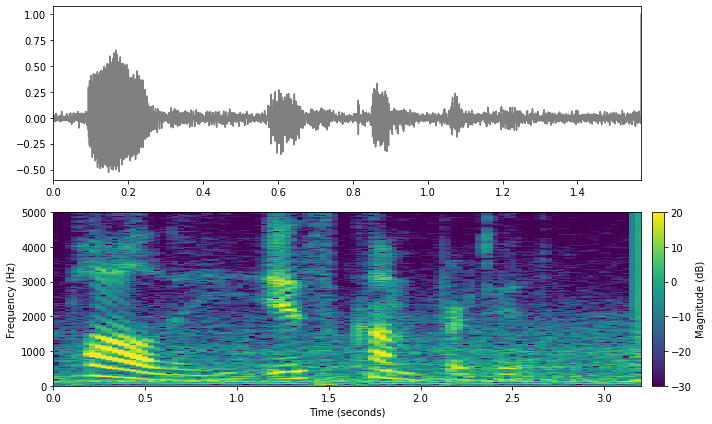

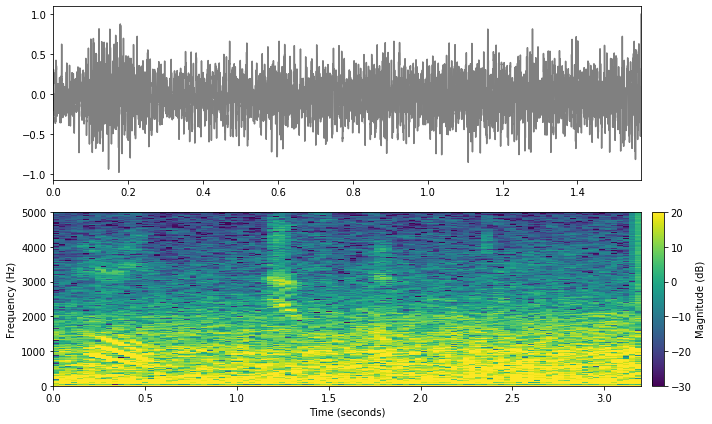

In [9]:
def show_spec(x, N=1024, Fs=16000):
  H = N//2
  Fs = 16000
  X = np.abs(librosa.stft(x, n_fft=N))
  Y = np.abs(X) ** 2
  eps = np.finfo(float).eps
  Y_db = 10 * np.log10(Y + eps)

  T_coef = np.arange(X.shape[1]) * H / Fs
  F_coef = np.arange(X.shape[0]) * Fs / N


  fig = plt.figure(figsize=(10, 6))

  gs = matplotlib.gridspec.GridSpec(2, 2, width_ratios=[100, 2])

  ax1, ax2, ax3, ax4 = [plt.subplot(gs[i]) for i in range(4)]

  t = np.arange(len(x)) / Fs
  ax1.plot(t, x, c='gray')
  ax1.set_xlim([min(t), max(t)])

  ax2.set_visible(False)

  left = min(T_coef)
  right = max(T_coef) + N / Fs
  lower = min(F_coef)
  upper = max(F_coef)

  im = ax3.imshow(Y_db, origin='lower', aspect='auto', cmap='viridis', 
                  extent=[left, right, lower, upper])
  im.set_clim([-30, 20])
  ax3.set_ylim([0, 5000])
  ax3.set_xlabel('Time (seconds)')
  ax3.set_ylabel('Frequency (Hz)')
  cbar = fig.colorbar(im, cax=ax4)
  ax4.set_ylabel('Magnitude (dB)', rotation=90)

  plt.tight_layout()

show_spec(mixture1)
show_spec(mixture2)

# **Make trainset**

In [0]:
# ! rm -r ./data_npz
sampling_rate = 16000
train_paths = glob.glob('./data/train/*/*/*/*.wav')

for train_path in train_paths:
  dir_name, filename = os.path.split(train_path)
  npz_dir_name = dir_name.replace('/data/', '/data_npz/')
  npz_filename = filename.replace('.wav', '.npz')
  os.makedirs(npz_dir_name, exist_ok=True)
  y, _ = librosa.load(train_path, sr=sampling_rate, res_type='kaiser_fast')
  save_path = os.path.join(npz_dir_name, npz_filename)
  if 'source' in npz_dir_name:
    np.savez(save_path, source=y)
  elif 'noise' in npz_dir_name:
    np.savez(save_path, noise=y)

# **Make evaluation set**

*   Make .json hierarchy file



In [11]:
import glob
import os
import json

def get_files(path, extension='.wav'):
	filenames = []
	for (path, dir, files) in os.walk(path):
		for filename in files:
			ext = os.path.splitext(filename)[-1]
			if ext == extension:
				filenames.append(os.path.join(path,filename))
	return filenames


spks_for_val = ['spk1','spk2']
src_path = './data/valid/source/*'
src_classes = glob.glob(src_path)
print(src_classes)
src_cls = src_classes[0]
spks_path = glob.glob(os.path.join(src_cls,'*'))
print(spks_path)

['./data/valid/source/speech']
['./data/valid/source/speech/spk2', './data/valid/source/speech/spk1']


In [0]:
# ! mkdir eval_settings

import glob
import os
import json

def get_files(path, extension='.wav'):
	filenames = []
	for (path, dir, files) in os.walk(path):
		for filename in files:
			ext = os.path.splitext(filename)[-1]
			if ext == extension:
				filenames.append(os.path.join(path,filename))
	return filenames


spks_for_val = ['spk1','spk2']
src_path = './data/valid/source/*'
src_classes = glob.glob(src_path)
src_dict = {}
for src_cls in src_classes:
    spks_path = glob.glob(os.path.join(src_cls,'*'))
    spk_dict = {}
    for spk in spks_path:
        spk_dict['{}'.format(os.path.basename(spk))] = get_files(spk)
    src_dict[os.path.basename(src_cls)] = spk_dict
# {"speech": {'spk1':[wavpath/path/sound.wav,...], 'spk2':...}, "singing": {'singer1':[wavpath/path/sound.wav]}}
for src in list(src_dict.keys()):
    spks = list(src_dict[src].keys())
    for spk in spks:
        if spk in spks_for_val:
            pass
        else:
            del src_dict[src][spk]
        

noise_path = './data/valid/noise/*'
noise_classes = glob.glob(noise_path)
noise_dict = {}
for noise_cls in noise_classes:
    snds_path = glob.glob(os.path.join(noise_cls,'*'))
    snd_dict = {}
    for snd in snds_path:
        snd_dict['{}'.format(os.path.basename(snd))] = get_files(snd)
    noise_dict[os.path.basename(noise_cls)] = snd_dict
# {"stationary": {'spk1':[wavpath/path/sound.wav]}, "non-stationary": {'singer1':[wavpath/path/sound.wav]}, 'musical': {}}

val_dict = {}
val_dict['source'] = src_dict
val_dict['noise'] = noise_dict
!mkdir eval_settings
with open('./eval_settings/valid_class.json', 'w') as fp: 
    json.dump(val_dict, fp, sort_keys=True, indent=4)


In [15]:
print(val_dict)

{'source': {'spk2': {}, 'spk1': {}}, 'noise': {'non_stationary': {'chime': ['./data/valid/noise/non_stationary/chime/NlqxVBVhLiU.wav'], 'car_alarm': ['./data/valid/noise/non_stationary/car_alarm/UbkUtLiMNSI.wav', './data/valid/noise/non_stationary/car_alarm/AFY3Mn_j0e8.wav', './data/valid/noise/non_stationary/car_alarm/cMatnDQqzjw.wav', './data/valid/noise/non_stationary/car_alarm/XP8F1T7dk94.wav', './data/valid/noise/non_stationary/car_alarm/lnClssYHVsE.wav', './data/valid/noise/non_stationary/car_alarm/qvOdAaqot4Q.wav', './data/valid/noise/non_stationary/car_alarm/owicXXGeWQco.wav', './data/valid/noise/non_stationary/car_alarm/qjl7XXzxkTx8.wav', './data/valid/noise/non_stationary/car_alarm/VCIm4ljZWac.wav']}, 'stationary': {'washing_machine': ['./data/valid/noise/stationary/washing_machine/07027232.wav'], 'fans': ['./data/valid/noise/stationary/fans/07041006.wav']}, 'musical': {'punkrock': ['./data/valid/noise/musical/punkrock/j4OXXc4hSDYI.wav', './data/valid/noise/musical/punkrock/3

valid_class.json file을 확인해보겠습니다.
json file의 hierarchy는 다음과 같습니다.


source                                                      

----------source class (**speech** or singing, 본 lecture에서는 speech만 사용)

--------------------------------speakers (spk1, spk2)

noise

----------noise class (coarse definition: musical, non_stationary, stationary)

--------------------------------sound type (afrobeat, punkrock, washing machine, fans, etc...)


In [13]:
with open('./eval_settings/valid_class.json', 'r') as fp:
    valid_dict = json.load(fp)

    valid_src_dict = valid_dict['source']
    valid_spk_dict = valid_dict['source']['speech']
    valid_spk1_list = valid_dict['source']['speech']['spk1']

    valid_noise_dict = valid_dict['noise']
    valid_snd_dict = valid_dict['noise']['musical']
    valid_afrobeat_list = valid_dict['noise']['musical']['afrobeat']

    print("valid_dict keys: {}".format(list(valid_dict.keys())))
    print("valid_src_dict keys: {}".format(list(valid_src_dict.keys())))
    print("valid_spk_dict keys: {}".format(list(valid_spk_dict.keys())))
    print("valid_spk1_list: {}".format(valid_spk1_list))

    

valid_dict keys: ['noise', 'source']
valid_src_dict keys: ['speech']
valid_spk_dict keys: ['spk1', 'spk2']
valid_spk1_list: ['./data/valid/source/speech/spk1/84_121550_000294_000000.wav', './data/valid/source/speech/spk1/84_121550_000150_000000.wav', './data/valid/source/speech/spk1/84_121550_000256_000000.wav', './data/valid/source/speech/spk1/84_121123_000012_000007.wav', './data/valid/source/speech/spk1/84_121123_000048_000000.wav', './data/valid/source/speech/spk1/84_121123_000045_000002.wav', './data/valid/source/speech/spk1/84_121123_000029_000000.wav', './data/valid/source/speech/spk1/84_121550_000253_000000.wav', './data/valid/source/speech/spk1/84_121550_000272_000000.wav', './data/valid/source/speech/spk1/84_121550_000106_000000.wav', './data/valid/source/speech/spk1/84_121550_000144_000000.wav', './data/valid/source/speech/spk1/84_121550_000036_000000.wav', './data/valid/source/speech/spk1/84_121123_000009_000007.wav', './data/valid/source/speech/spk1/84_121550_000063_000000

*   SNR 별 Mixture 만들기

In [15]:
! rm -r ./data_npz/valid
import random

def make_evalset(out_dir, json_path, mapping_dict, snr_val=[-10., -5., 0., 5., 10.], num_max_samples=10):
  with open(json_path, 'r') as fp:
      val_dict = json.load(fp)
      val_src_dict = val_dict['source']['speech']
      val_noise_dict = val_dict['noise']

      for snr in snr_val:
          print('Processing snr: {} (dB)'.format(snr))      
          noise_types = list(val_noise_dict.keys())
          for noise_type in noise_types:
              # noise_type: stationary, non-stationary, musical
              out_dir_ = os.path.join(out_dir, str(snr), noise_type)
              snd_types = list(val_noise_dict[noise_type].keys())
              for snd in snd_types:
                  # snd: Fans, NewYork, etc...
                  npz_out_dir = os.path.join(out_dir_, snd)

                  os.makedirs(npz_out_dir, exist_ok=True)

                  noise_list = val_noise_dict[noise_type][snd]

                  for noise_path in noise_list:
                      y, _ = librosa.load(noise_path, sr=sample_rate) # load noise
                      spk_to_add = mapping_dict[noise_type][snd]
                      for spk in spk_to_add:
                          src_list = val_src_dict[spk]
                          src_list = src_list[:num_max_samples]
                          for i, src_path in enumerate(src_list):
                              x, _ = librosa.load(src_path, sr=sample_rate, res_type='kaiser_fast')
                              x = rms_normalize(x, ref_dB=-23.) # load source

                              y_crop = random_select(y, sample_len=len(x))
                              
                              mix, source, noise = adjust_noise(noise=y_crop, source=x, snr=snr)

                              src_name = os.path.basename(src_path).replace('.wav','')
                              noise_name = os.path.basename(noise_path).replace('.wav','')
                              
                              filename = '{}|{}|{}|{}|{}.npz'.format(i,spk,src_name,snd,noise_name)
                              npz_filename = os.path.join(npz_out_dir, filename)
                              np.savez(npz_filename, mixture=mix, source=source, noise=noise)


### Make Evaluation Set ###
sample_rate = 16000
num_max_srcs = 10

val_stationary_mapping = {\
'fans':['spk1'],
'washing_machine':['spk2'],
}
val_nonstationary_mapping = {\
'car_alarm':['spk1'],
'chime':['spk2'],
}
val_musical_mapping = {\
'afrobeat':['spk1'],
'punkrock':['spk2'],
}
val_mapping = {\
'stationary':val_stationary_mapping,
'non_stationary':val_nonstationary_mapping,
'musical':val_musical_mapping,
}

make_evalset('./data_npz/valid', './eval_settings/valid_class.json', val_mapping, snr_val=[-5., 5.], num_max_samples=10)


Processing snr: -5.0 (dB)
Processing snr: 5.0 (dB)


만들어진 소리를 들어보자.

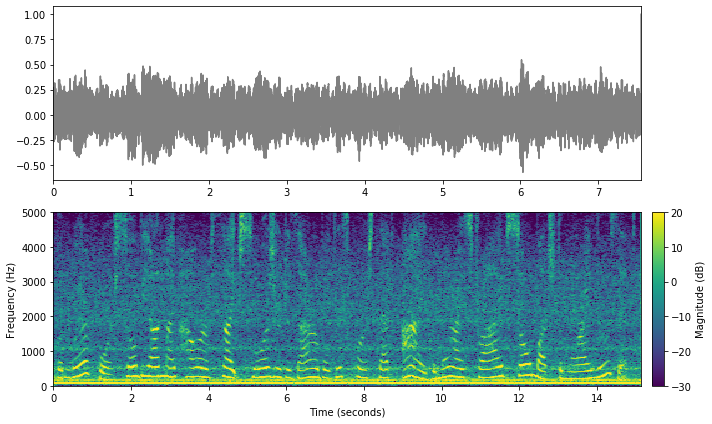

In [20]:
# from -5 dB mixture
mixture = np.load('/content/data_npz/valid/-5.0/stationary/fans/0|spk1|84_121550_000294_000000|fans|07041006.npz')['mixture']
mixture[-1] = 1 # to prevent normalization in ipd.Audio...
ipd.Audio(mixture, rate=16000, autoplay=False)
show_spec(mixture)

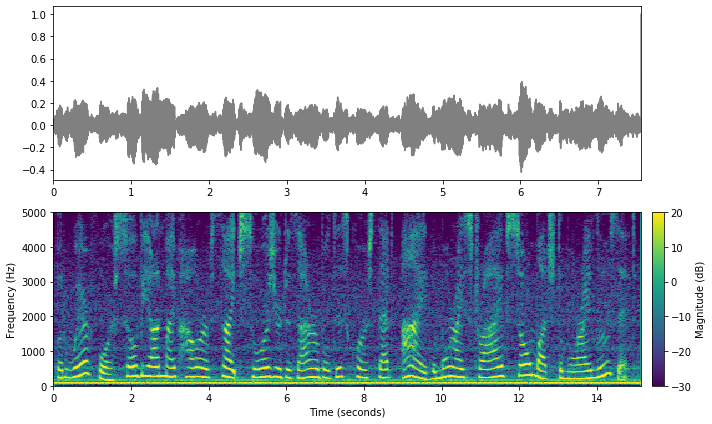

In [22]:
# from +5 dB mixture
mixture = np.load('/content/data_npz/valid/5.0/stationary/fans/0|spk1|84_121550_000294_000000|fans|07041006.npz')['mixture']
mixture[-1] = 1 # to prevent normalization in ipd.Audio...
ipd.Audio(mixture, rate=16000, autoplay=False)
show_spec(mixture)

# **Make data loader**



In [0]:
class TrainLoader(tf.keras.utils.Sequence):
  def __init__(self, batch_size=32, target_len=17152,
               snr_min=-10., snr_max=20., snr_step=1.,
               ref_min=-30., ref_max=30., ref_step=1.,
               shuffle=True):
    self.target_len = target_len
    self.batch_size = batch_size    
    self.src_list_IDs = glob.glob('./data_npz/train/source/*/*/*.npz')
    self.noise_list_IDs = glob.glob('./data_npz/train/noise/*/*/*.npz')
    self.shuffle = shuffle
    self.snr_list = list(np.arange(snr_min, snr_max+snr_step, snr_step))
    self.dB_list = list(np.arange(ref_min, ref_max+ref_step, ref_step))
    self.on_epoch_end()

  def __len__(self):
    # number of batches
    return int(len(self.src_list_IDs) // self.batch_size)
    
  def __getitem__(self, index):
    # Generate indexes of the batch
    src_indexes = self.src_indexes[index*self.batch_size:(index+1)*self.batch_size]
    noise_indexes = random.sample(list(self.noise_indexes), self.batch_size) # random sample the indices

    # Find list of IDs
    src_list_IDs_temp = [self.src_list_IDs[k] for k in src_indexes]
    noise_list_IDs_temp = [self.noise_list_IDs[k] for k in noise_indexes]

    # Generate data
    mix, src, noise = self.__data_generation(src_list_IDs_temp, noise_list_IDs_temp, wav_type='source')
    return mix, src, noise
  
  def on_epoch_end(self):
    self.src_indexes = np.arange(len(self.src_list_IDs))
    self.noise_indexes = np.arange(len(self.noise_list_IDs))
    if self.shuffle == True:
        np.random.shuffle(self.src_indexes)
        np.random.shuffle(self.noise_indexes)

  def __data_generation(self, src_list_IDs_temp, noise_list_IDs_temp, wav_type):
    # wav : (n_samples, 1, target_len)
    # Initialization
    batch_mix = np.empty((self.batch_size, self.target_len))
    batch_src = np.empty((self.batch_size, self.target_len))
    batch_noise = np.empty((self.batch_size, self.target_len))
    
    
    # Generate data
    for i, (src_ID, noise_ID) in enumerate(zip(src_list_IDs_temp, noise_list_IDs_temp)):
      # Store sample
      src = np.load(src_ID)['source']
      noise = np.load(noise_ID)['noise']

      # Crop or zeropad the wav to be the target length
      src_len = src.shape[0]
      if src_len < self.target_len:
        # zero padding
        l_pad = int((self.target_len - src_len)//2)
        r_pad = int(self.target_len - src_len - l_pad)
        src = np.pad(src, (l_pad, r_pad), 'constant', constant_values=(0., 0.))
      else:
        # crop
        end = random.randint(self.target_len, src_len)
        start = int(end-self.target_len)
        src = src[start:end]

      noise_len = noise.shape[0]
      if noise_len < self.target_len:
        # zero padding
        l_pad = int((self.target_len - noise_len)//2)
        r_pad = int(self.target_len - noise_len - l_pad)
        noise = np.pad(noise, (l_pad, r_pad), 'constant', constant_values=(0., 0.))
      else:
        # crop
        end = random.randint(self.target_len, noise_len)
        start = int(end-self.target_len)
        noise = noise[start:end]        
      

      # Adjust scale
      dB = random.sample(self.dB_list, 1)[0]
      src = rms_normalize(src, dB)

      snr = random.sample(self.snr_list, 1)[0]
      mixture, speech, noise = adjust_noise(noise, src, snr)

      batch_src[i] = src
      batch_noise[i] = noise
      batch_mix[i] = mixture

    return batch_mix, batch_src, batch_noise


# loader=TrainLoader()
# one_epoch_steps = len(loader)
# total_epochs = 5
# for epoch in range(1, total_epochs+1):
#   for i, (mix, src, noise) in enumerate(loader, 1):
#     print("step[{}/{}], epoch[{}/{}]".format(i, one_epoch_steps, epoch, total_epochs))
#     print(src.shape)
#     print(noise.shape)
#     print(mix.shape)

# **Deep learning models (U-Net) for audio source separation**


*   U-Net
*   Mask-based source separation


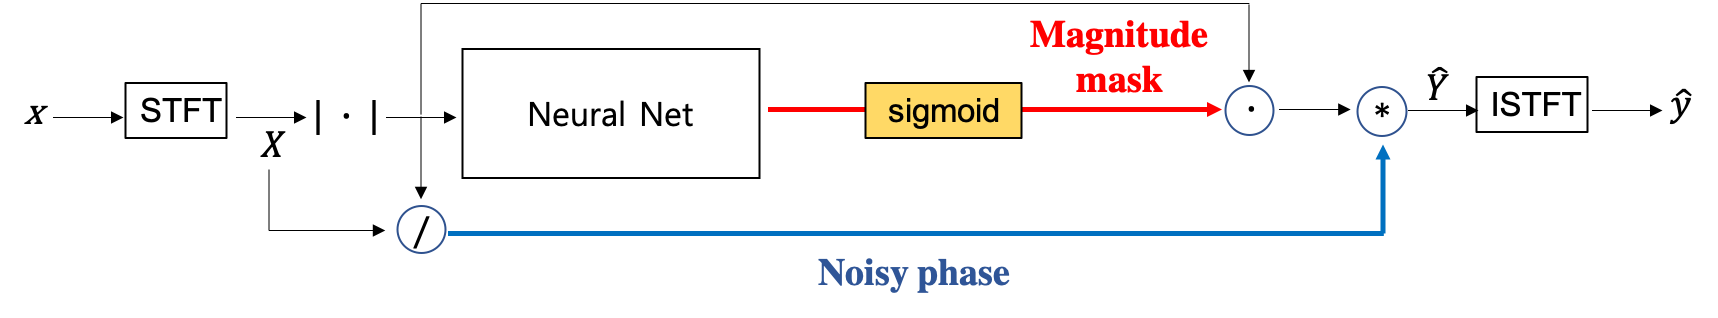

In [0]:
from IPython.display import Image
Image(filename='/content/drive/My Drive/Colab Notebooks/mask_based_separation.png')

**Convolution Blocks & U-Net**

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.python.layers import utils 

def conv2d(name, input, oc, f_h=3, f_w=3, s_h=1, s_w=1, bn=True, is_training=True, print_shape=False, act='lrelu'):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE) as scope:

        input_shape = input.get_shape().as_list()
        W = tf.get_variable("W", shape=[f_h, f_w, input_shape[-1], oc],
                            initializer=tf.contrib.layers.xavier_initializer())

        conv = tf.nn.conv2d(input, W, strides=[1, s_h, s_w, 1], padding="SAME", name="conv")

        if bn == True:
            bn = tf.contrib.layers.batch_norm(conv,
                                          center=True, scale=True,
                                          is_training=is_training,
                                          scope='bn')
        else:
            # No batch normalization
            bn = conv

        if act == 'relu':
            # ReLU
            act = tf.nn.relu(bn)
        elif act == 'lrelu':
            # Leaky ReLU
            act = tf.nn.leaky_relu(bn)
        else:
            # No activation
            act = bn

        if print_shape== True:
            print("{} shape : {}".format(act.name, act.get_shape()))
        return act


def deconv2d(name, input, oc, f_h=3, f_w=3, s_h=1, s_w=1, bn=True, is_training=True, print_shape=False, act='lrelu'):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE) as scope:

        padding = "SAME"
        input_shape = input.get_shape().as_list()
        out_h = utils.deconv_output_length(input_shape[1], f_h, padding, s_h)
        out_w = utils.deconv_output_length(input_shape[2], f_w, padding, s_w)
        output_shape = (input_shape[0], out_h, out_w, oc)
        strides = [1, s_h, s_w, 1]

        W = tf.get_variable("W", shape=[f_h, f_w, oc, input_shape[-1]], initializer=tf.contrib.layers.xavier_initializer())

        deconv = tf.nn.conv2d_transpose(input, filter=W, output_shape=output_shape, strides=strides, padding=padding)

        if bn == True:
            bn = tf.contrib.layers.batch_norm(deconv,
                                          center=True, scale=True,
                                          is_training=is_training,
                                          scope='bn')
        else:
            # No batch normalization
            bn = deconv

        if act == 'relu':
            # ReLU
            act = tf.nn.relu(bn)
        elif act == 'lrelu':
            # Leaky ReLU
            act = tf.nn.leaky_relu(bn)
        else:
            # No activation
            act = bn

        if print_shape== True:
            print("{} shape : {}".format(act.name, act.get_shape()))
        return act


class Separator(object):
  def __init__(self, use_log=True):
      self.use_log = use_log
  def run(self, input, is_training=True, print_shape=False):
      self.input = input[:,:,:-1,:]
      self.is_training=is_training

      with tf.variable_scope("Separator", reuse=tf.AUTO_REUSE):

        """
        Using log
        """
        if self.use_log == True:
          self.input = tf.log(self.input + 1e-5)
        else:
          pass

        if print_shape:
          print("{} shape : {}".format(self.input.name, self.input.get_shape()))

        # (64, 512)
        self.conv1 = conv2d("conv1", self.input, oc=45, f_h=4, f_w=4, s_h=2, s_w=2, bn=False, act='lrelu',
                            print_shape=print_shape, is_training=self.is_training)
        # (32, 256)
        self.conv2 = conv2d("conv2", self.conv1, oc=90, f_h=4, f_w=4, s_h=2, s_w=2, bn=True, act='lrelu',
                            print_shape=print_shape, is_training=self.is_training)
        # (16, 128)
        self.conv3 = conv2d("conv3", self.conv2, oc=90, f_h=4, f_w=4, s_h=2, s_w=2, bn=True, act='lrelu',
                            print_shape=print_shape, is_training=self.is_training)
        # (8, 64)
        self.conv4 = conv2d("conv4", self.conv3, oc=90, f_h=4, f_w=4, s_h=2, s_w=2, bn=True, act='lrelu',
                            print_shape=print_shape, is_training=self.is_training)                
        # (4, 32)
        self.conv5 = conv2d("conv5", self.conv4, oc=90, f_h=4, f_w=4, s_h=1, s_w=1, bn=True, act='lrelu',
                            print_shape=print_shape, is_training=self.is_training)
        # (4, 32)


        self.deconv1 = deconv2d("deconv1", self.conv5, oc=90, f_h=4, f_w=4, s_h=1, s_w=1, bn=True, act='lrelu',
                                print_shape=print_shape, is_training=self.is_training)
        # (4, 32)
        self.d1 = tf.concat([self.deconv1, self.conv4], axis=-1)
        self.deconv2 = deconv2d("deconv2", self.d1, oc=90, f_h=4, f_w=4, s_h=2, s_w=2, bn=True, act='lrelu',
                                print_shape=print_shape, is_training=self.is_training)
        # (8, 64)
        self.d2 = tf.concat([self.deconv2, self.conv3], axis=-1)
        self.deconv3 = deconv2d("deconv3", self.d2, oc=90, f_h=4, f_w=4, s_h=2, s_w=2, bn=True, act='lrelu',
                                print_shape=print_shape, is_training=self.is_training)
        # (16, 128)
        self.d3 = tf.concat([self.deconv3, self.conv2], axis=-1)
        self.deconv4 = deconv2d("deconv4", self.d3, oc=45, f_h=4, f_w=4, s_h=2, s_w=2, bn=True, act='lrelu',
                                print_shape=print_shape, is_training=self.is_training)                                                        
        # (32, 256)
        self.d4 = tf.concat([self.deconv4, self.conv1], axis=-1)
        self.out = deconv2d("deconv5", self.d4, oc=1, f_h=4, f_w=4, s_h=2, s_w=2, bn=False, act=None,
                            print_shape=print_shape, is_training=self.is_training)
        # (64, 512)

          
        print("Sigmoid Mask")
        self.out = tf.nn.sigmoid(self.out)
        
        return self.out

# **Training**


*   Build graph



In [25]:
eps = np.finfo(np.float32).eps
bs = 32

def real_imag(cplx_spec):
    c = int(int(cplx_spec.get_shape()[-1])/2)
    return cplx_spec[:,:,:,:c], cplx_spec[:,:,:,c:]

def magnitude(cplx_spec, name='magnitude'):
    real = cplx_spec[:,:,:,0:1]
    imag = cplx_spec[:,:,:,1:2]
    mag = tf.sqrt(tf.square(real)+tf.square(imag)+eps)
    tf.identity(mag, name=name)
    return mag


######### Build graph #########

# Define placeholders (batch, sample_length)
mix_ph = tf.placeholder(shape=(bs, 17152), dtype=tf.float32)
src_ph = tf.placeholder(shape=(bs, 17152), dtype=tf.float32)

# Convert to spectrogram
mix_cplx_spec = tf.signal.stft(mix_ph, frame_length=1024, frame_step=256, fft_length=1024) # shape: (batch, frame, freq)
mix_cplx_spec = tf.expand_dims(mix_cplx_spec, axis=-1) # shape: (batch, frame, freq, 1)
mix_cplx_spec = tf.concat([tf.real(mix_cplx_spec), tf.imag(mix_cplx_spec)], axis=-1) # shape: (batch, frame, freq, 2)
mix_mag_spec = magnitude(mix_cplx_spec)
mix_phase = mix_cplx_spec/(mix_mag_spec+eps) # shape: (batch, frame, freq, 2)

src_cplx_spec = tf.signal.stft(src_ph, frame_length=1024, frame_step=256, fft_length=1024) # shape: (batch, frame, freq)
src_cplx_spec = tf.expand_dims(src_cplx_spec, axis=-1) # shape: (batch, frame, freq, 1)
src_cplx_spec = tf.concat([tf.real(src_cplx_spec), tf.imag(src_cplx_spec)], axis=-1) # shape: (batch, frame, freq, 2)
src_mag_spec = magnitude(src_cplx_spec) # shape: (batch, frame, freq, 1)

# Define separator
separator = Separator(use_log=True)

# Pass the mixture into the separator function
mask = separator.run(mix_mag_spec, is_training=True, print_shape=True)
est_src_mag_spec = mask * mix_mag_spec[:,:,:-1,:]

# Define loss function
loss = tf.reduce_mean(tf.abs(est_src_mag_spec - src_mag_spec[:,:,:-1,:]))

# Define optimizer
trainer = tf.train.AdamOptimizer(2e-4, beta1=0.5, beta2=0.9).minimize(loss, var_list= tf.trainable_variables())            

# Convert the estimated spectrogram into waveform domain
paddings = tf.constant([[0,0],[0,0],[0,1],[0,0]])
est_src_mag_spec = tf.pad(est_src_mag_spec, paddings)
est_src_cplx_spec = est_src_mag_spec * mix_phase
est_src_cplx_spec = tf.complex(est_src_cplx_spec[:,:,:,0],est_src_cplx_spec[:,:,:,1])
est_src = tf.signal.inverse_stft(est_src_cplx_spec, frame_length=1024, frame_step=256, fft_length=1024,window_fn=tf.contrib.signal.inverse_stft_window_fn(256))
  

Separator/Log:0 shape : (32, 64, 512, 1)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Separator/conv1/LeakyRelu:0 shape : (32, 32, 256, 45)
Instructions for updating:
Please use `layer.__call__` method instead.
Separator/conv2/LeakyRelu:0 shape : (32, 16, 128, 90)
Separator/conv3/LeakyRelu:0 shape : (32, 8, 64, 90)
Separator/conv4/LeakyRelu:0 shape : (32, 4, 32, 90)
Separator/conv5/LeakyRelu:0 shape : (32, 4, 32, 90)
Separator/deconv1/LeakyRelu:0 shape : (32, 4, 32, 90)
Separator/deconv2/LeakyRelu:0 shape : (32, 8, 64, 90)
Separator/deconv3/LeakyRelu:0 shape : (32, 16, 128, 90)
Separator/deconv4/LeakyRelu:0 shape : (32, 32, 256, 45)
Separator/deconv5/conv2d_transpose:0 sha

*   Optimization

In [26]:
loader=TrainLoader(batch_size=32, target_len=17152)
one_epoch_steps = len(loader)
total_epochs = 100

init = tf.global_variables_initializer()
with tf.Session() as sess:
  sess.run(init)
  for epoch in range(1, total_epochs+1):
    for i, (mix, src, noise) in enumerate(loader, 1):
        _, loss_value = sess.run([trainer, loss], feed_dict={mix_ph:mix, src_ph:src})
        print("loss: {} | (step[{}/{}], epoch[{}/{}])".format(loss_value, i, one_epoch_steps, epoch, total_epochs)) 


loss: 11.115535736083984 | (step[1/9], epoch[1/100])
loss: 22.718721389770508 | (step[2/9], epoch[1/100])
loss: 15.303730010986328 | (step[3/9], epoch[1/100])
loss: 13.294174194335938 | (step[4/9], epoch[1/100])
loss: 17.390056610107422 | (step[5/9], epoch[1/100])
loss: 12.137303352355957 | (step[6/9], epoch[1/100])
loss: 25.680910110473633 | (step[7/9], epoch[1/100])
loss: 28.363920211791992 | (step[8/9], epoch[1/100])
loss: 14.837125778198242 | (step[9/9], epoch[1/100])
loss: 12.893036842346191 | (step[1/9], epoch[2/100])
loss: 20.9617919921875 | (step[2/9], epoch[2/100])
loss: 19.391775131225586 | (step[3/9], epoch[2/100])
loss: 27.082931518554688 | (step[4/9], epoch[2/100])
loss: 13.169742584228516 | (step[5/9], epoch[2/100])
loss: 13.807646751403809 | (step[6/9], epoch[2/100])
loss: 24.88983917236328 | (step[7/9], epoch[2/100])
loss: 28.67389488220215 | (step[8/9], epoch[2/100])
loss: 20.09600067138672 | (step[9/9], epoch[2/100])
loss: 16.543453216552734 | (step[1/9], epoch[3/100]

# **Test**

In [0]:
def test(mixture, save_path=None, which_model='large_model', model_number=1000000, sr=16000, save=True):

  model_path = "/content/drive/My Drive/Colab Notebooks/checkpoints/{}".format(which_model)
  model_number_path="model.ckpt-{}".format(model_number)

  """
  Make Saving Directories
  """
  NUM_THREADS=3
  configuration=tf.ConfigProto(inter_op_parallelism_threads=NUM_THREADS,\
                      intra_op_parallelism_threads=NUM_THREADS,\
                      allow_soft_placement=True,\
                      device_count = {'CPU': 3},\
                      )

  with tf.Session(config=configuration) as sess:
      meta_graph_path = '/content/drive/My Drive/Colab Notebooks/checkpoints/{}/model.ckpt-{}.meta'.format(which_model, model_number)
      restorer = tf.train.import_meta_graph(meta_graph_path)
      graph = tf.get_default_graph()    
      tf.global_variables_initializer().run() #Initialize

      mix_test = graph.get_tensor_by_name("DeepComplexUnet/mixture_sample:0")
      est = graph.get_tensor_by_name("DeepComplexUnet/estimation_test:0")


      # print("\nMODEL PATH : ",model_path)
      ckpt = tf.train.get_checkpoint_state(checkpoint_dir=model_path)
      ckpt_list = ckpt.all_model_checkpoint_paths
      
      model_exist = False
      for model in ckpt_list:
        if model_number_path in model.split("/")[-1]:
          model_exist=True
          # print("Check point path : ", model) 
          restorer.restore(sess, model)  
          # print('Restored!')
          continue
      if model_exist == False:
        print("No model number {}".format(model_number))


      moving_rate = 4
      hop = int(33536/moving_rate) # This have to be an interger without any rounding                                

      mask = (1/moving_rate)

      mixture_length = mixture.shape[0]
      num_frame = int(mixture_length/33536)+1

      # pad zeros to mixture to make the length of it be the multiple of 33536
      mixture = np.lib.pad(mixture, (0,num_frame*33536-mixture_length), 'reflect')
      padded_mixture_shape = mixture.shape[0]
      mixture = np.expand_dims(mixture,axis=0) # ex: (1, 6897664)

      # Slice mixture
      mixture_slice_list = []

      num_to_move = int((padded_mixture_shape-33536)/hop) + 1
      for i in range(num_to_move): # it is already including extra segments(+1) since we padded the zeros to the last part of the mixture
        start_point = int(i*hop)
        end_point = int(start_point + 33536)
        slice = mixture[:,start_point:end_point] # ex: (1,16384)
        mixture_slice_list.append(slice)
      num_slice = len(mixture_slice_list)

      # Separation
      segments = []
      for i in range(num_slice): 
        estimated_sample = sess.run(est, feed_dict={mix_test: mixture_slice_list[i]})
        masked_sample = mask*estimated_sample
        segments.append(masked_sample)

      temp = np.zeros(shape=(padded_mixture_shape))
      for i in range(len(segments)):
        start_point = int(i*hop)
        end_point = int(start_point + 33536)
        temp[start_point:end_point] = temp[start_point:end_point] + segments[i]

      # Match the original mixture length
      estimation = temp[:mixture_length]

      if save == False:
        pass
      else:
        librosa.output.write_wav(save_path, estimation, sr)

      return estimation


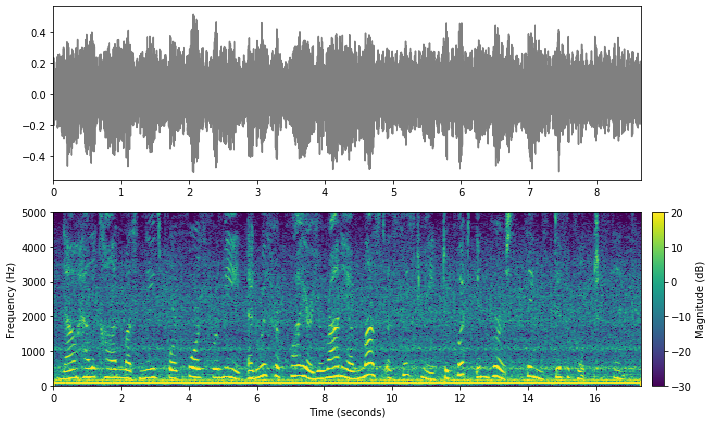

In [0]:
y1 = np.load('/content/data_npz/valid/-5.0/stationary/fans/0|spk1|84_121550_000072_000000|fans|07041006.npz')['mixture']
ipd.Audio(y1, rate=16000, autoplay=False)
show_spec(y1)


In [0]:
estimation1 = test(y1, save=False)
ipd.Audio(estimation1, rate=16000, autoplay=False)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Colab Notebooks/checkpoints/large_model/model.ckpt-1000000


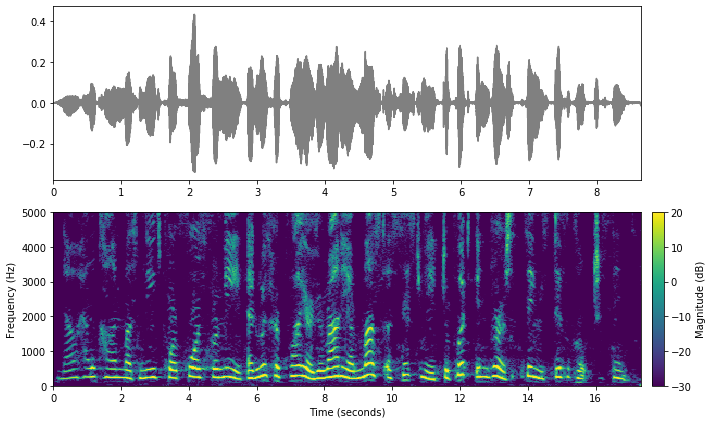

In [0]:
show_spec(estimation1)

In [0]:
y2 = np.load('/content/data_npz/valid/-5.0/non_stationary/car_alarm/0|spk1|84_121550_000072_000000|car_alarm|cMatnDQqzjw.npz')['mixture']
ipd.Audio(y2, rate=16000, autoplay=False)

In [0]:
estimation2 = test(y2, save_path='./samples/separated2.wav')
ipd.Audio(estimation2, rate=16000, autoplay=False)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Colab Notebooks/checkpoints/large_model/model.ckpt-1000000


In [0]:
y3 = np.load('/content/data_npz/valid/-5.0/musical/punkrock/0|spk2|174_84280_000005_000007|punkrock|3zPvfVmL0nE.npz')['mixture']
ipd.Audio(y3, rate=16000, autoplay=False)

In [0]:
estimation3 = test(y3, save_path='./samples/separated3.wav')
ipd.Audio(estimation3, rate=16000, autoplay=False)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Colab Notebooks/checkpoints/large_model/model.ckpt-1000000


In [0]:
# Separate valid samples (optional)
valid_npz_paths = glob.glob('./data_npz/valid/*/*/*/*.npz')
for org_path in valid_npz_paths:
  dir_name, filename = os.path.split(org_path)
  result_dir_name = dir_name.replace('/data_npz/', '/result/')
  result_filename = filename.replace('.npz', '.wav')
  os.makedirs(result_dir_name, exist_ok=True)
  y = np.load(org_path)['mixture']
  save_path = os.path.join(result_dir_name, result_filename)

  test(y, save_path, which_model='large_model', model_number=1000000)

# **Evaluation**

*   SDR
*   SNR




많이 쓰이는 평가 코드들...
1. Speech enhancement: https://www.crcpress.com/downloads/K14513/K14513_CD_Files.zip
2. Music source separation: https://github.com/sigsep/sigsep-mus-eval
3. SDR: http://bass-db.gforge.inria.fr/bss_eval/

In [0]:
def sdr(est, src):
  num = np.sum(est * src)**2
  den = np.sum(est**2) * np.sum(src**2) - num
  
  return 10*np.log10(num/(den+eps))

In [0]:
mix = np.load('/content/data_npz/valid/-5.0/musical/punkrock/0|spk2|174_84280_000005_000007|punkrock|3zPvfVmL0nE.npz')['mixture']
src = np.load('/content/data_npz/valid/-5.0/musical/punkrock/0|spk2|174_84280_000005_000007|punkrock|3zPvfVmL0nE.npz')['source']
print("SDR between mixture and source: {}".format(sdr(mix, src)))
print("SDR between estimation and source: {}".format(sdr(estimation3, src)))

SDR between mixture and source: -5.0500477408337465
SDR between estimation and source: 4.9221242271470755


# also see

* looking to listen 
https://www.youtube.com/watch?v=rVQVAPiJWKU
https://arxiv.org/pdf/1804.03619.pdf


* the sound of pixels
https://arxiv.org/pdf/1804.03160.pdf
http://sound-of-pixels.csail.mit.edu/


* online music source separation services
https://moises.ai/tasks



# External Example : Music Generation with RNN

In [0]:
!wget --no-check-certificate -qq -r 'https://docs.google.com/uc?export=download&id=1AHPitQ44btKqjb8f6bDZuddq45pD23tz' -O data_midigen.zip
!unzip -qq /content/data_midigen.zip -d ./ 


!wget --no-check-certificate -qq -r 'https://docs.google.com/uc?export=download&id=1wSfdxanBhgWoQlQF6bxp1g58ShrEK2rq' -O midi_songs_midigen.zip
!unzip -qq /content/midi_songs_midigen.zip -d ./ 


In [2]:
import glob
import pickle
import numpy
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [4]:

def get_notes():
    notes = []
    print('num of midi : ', len(glob.glob("midi_songs/*.mid")))
    for file in glob.glob("midi_songs/*.mid"):
        midi = converter.parse(file)

        # print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    with open('data/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes


notes = get_notes()
n_vocab = len(set(notes))

num of midi :  92


In [0]:
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

network_input, network_output = prepare_sequences(notes, n_vocab)


In [7]:
def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        64,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
    model.add(LSTM(64, return_sequences=True, recurrent_dropout=0.3,))
    model.add(LSTM(64))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model


model = create_network(network_input, n_vocab)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 64)           16896     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 64)           33024     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_3 (Activation)    (None, 64)               

In [0]:
def train(model, network_input, network_output):
    """ train the neural network """
    filepath =  "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    model.fit(network_input, network_output, epochs=200, batch_size=128, callbacks=callbacks_list)


In [9]:
train(model, network_input, network_output)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/200





57077/57077 [==============================] - 231s 4ms/step - loss: 5.0874
Epoch 2/200
57077/57077 [==============================] - 225s 4ms/step - loss: 4.5893
Epoch 3/200
57077/57077 [==============================] - 222s 4ms/step - loss: 4.5533
Epoch 4/200
17664/57077 [========>.....................] - ETA: 2:31 - loss: 4.5370

KeyboardInterrupt: ignored

In [0]:
def prepare_sequences(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 100
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    normalized_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    normalized_input = normalized_input / float(n_vocab)

    return (network_input, normalized_input)

def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        64,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
    model.add(LSTM(64, return_sequences=True, recurrent_dropout=0.3,))
    model.add(LSTM(64))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    # Load the weights to each node
    model.load_weights('weights-improvement-03-4.5533-bigger.hdf5')

    return model

def generate_notes(model, network_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = numpy.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='test_output.mid')


In [0]:
""" Generate a piano midi file """
#load the notes used to train the model
with open('data/notes', 'rb') as filepath:
    notes = pickle.load(filepath)

# Get all pitch names
pitchnames = sorted(set(item for item in notes))
# Get all pitch names
n_vocab = len(set(notes))

network_input, normalized_input = prepare_sequences(notes, pitchnames, n_vocab)
model = create_network(normalized_input, n_vocab)
prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
create_midi(prediction_output)


# See also... 


* MuseNet
https://openai.com/blog/musenet/


* MAGENTA
https://magenta.tensorflow.org/demos




# External Example : Speech Synthesis (Tacotron 2)

In [27]:
import os
from os.path import exists, join, expanduser

os.chdir(expanduser("~"))

wavenet_dir = "wavenet_vocoder"
if not exists(wavenet_dir):
  ! git clone https://github.com/r9y9/$wavenet_dir
  ! cd wavenet_vocoder && git checkout v0.1.1 && cd -
    
taco2_dir = "Tacotron-2"
if not exists(taco2_dir):
  ! git clone https://github.com/r9y9/$taco2_dir
  ! cd $taco2_dir && git checkout -B wavenet3 origin/wavenet3

Cloning into 'wavenet_vocoder'...
remote: Enumerating objects: 1390, done.
remote: Total 1390 (delta 0), reused 0 (delta 0), pack-reused 1390
Receiving objects: 100% (1390/1390), 20.19 MiB | 37.06 MiB/s, done.
Resolving deltas: 100% (709/709), done.
Note: checking out 'v0.1.1'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 6be7c72 Merge pull request #123 from cbrom/master
/root
Cloning into 'Tacotron-2'...
remote: Enumerating objects: 570, done.
remote: Total 570 (delta 0), reused 0 (delta 0), pack-reused 570
Receiving objects: 100% (570/570), 8.05 MiB | 38.87 MiB/s, done.
Resolving deltas: 100% (355/355), done.
Branch 

In [28]:
# Install dependencies
! pip install -q -U "tensorflow<=1.9.0"
! pip install -q -U "numpy<1.16"
! pip install -q -U "pysptk<=0.1.14"

os.chdir(join(expanduser("~"), taco2_dir))
! pip install -q -r requirements.txt

os.chdir(join(expanduser("~"), wavenet_dir))
! pip install -q -e '.[train]'

     |████████████████████████████████| 51.1MB 55kB/s 
     |████████████████████████████████| 573kB 57.1MB/s 
     |████████████████████████████████| 3.3MB 66.6MB/s 
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.9.0 which is incompatible.
ERROR: google-auth 1.7.2 has requirement setuptools>=40.3.0, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 13.9MB 242kB/s 
ERROR: plotnine 0.6.0 has requirement numpy>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.9.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: astropy 4.0 has requirement numpy>=1.16, but you'll have numpy 1.15.4 which is incompatible.
ERROR: a

In [29]:
import torch
import tensorflow
import pysptk
import numpy as np
tensorflow.__version__, pysptk.__version__, np.__version__

('1.15.0', '0.1.17', '1.17.5')

In [30]:
os.chdir(join(expanduser("~"), taco2_dir))
! mkdir -p logs-Tacotron
if not exists("logs-Tacotron/pretrained"):
  ! curl -O -L "https://www.dropbox.com/s/vx7y4qqs732sqgg/pretrained.tar.gz"
  ! tar xzvf pretrained.tar.gz
  ! mv pretrained logs-Tacotron

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   990    0   990    0     0    788      0 --:--:--  0:00:01 --:--:--  1484
100  288M  100  288M    0     0  7489k      0  0:00:39  0:00:39 --:--:-- 2092k
pretrained/
pretrained/checkpoint
pretrained/model.ckpt-189500.meta
pretrained/model.ckpt-189500.data-00000-of-00001
pretrained/model.ckpt-189500.index


In [31]:
os.chdir(join(expanduser("~"), wavenet_dir))
wn_preset = "20180510_mixture_lj_checkpoint_step000320000_ema.json"
wn_checkpoint_path = "20180510_mixture_lj_checkpoint_step000320000_ema.pth"

if not exists(wn_preset):
  !curl -O -L "https://www.dropbox.com/s/0vsd7973w20eskz/20180510_mixture_lj_checkpoint_step000320000_ema.json"
if not exists(wn_checkpoint_path):
  !curl -O -L "https://www.dropbox.com/s/zdbfprugbagfp2w/20180510_mixture_lj_checkpoint_step000320000_ema.pth"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1488  100  1488    0     0   1183      0  0:00:01  0:00:01 --:--:--  3468
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   990    0   990    0     0    713      0 --:--:--  0:00:01 --:--:--     0
100  282M  100  282M    0     0  21.1M      0  0:00:13  0:00:13 --:--:-- 27.2M


In [0]:
os.chdir(join(expanduser("~"), taco2_dir))

In [33]:
%%bash
cat << EOS > text_list.txt
This is really awesome!
This is text-to-speech online demonstration by Tacotron 2 and WaveNet.
Thanks for your patience.
EOS

cat text_list.txt

This is really awesome!
This is text-to-speech online demonstration by Tacotron 2 and WaveNet.
Thanks for your patience.


In [34]:
# Remove old files if exist
! rm -rf tacotron_output
! python synthesize.py --model='Tacotron' --mode='eval' \
  --hparams='symmetric_mels=False,max_abs_value=4.0,power=1.1,outputs_per_step=1' \
  --text_list=./text_list.txt

loaded model at logs-Tacotron/pretrained/model.ckpt-189500
Hyperparameters:
  allow_clipping_in_normalization: True
  attention_dim: 128
  attention_filters: 32
  attention_kernel: (31,)
  cleaners: english_cleaners
  cumulative_weights: True
  decoder_layers: 2
  decoder_lstm_units: 1024
  embedding_dim: 512
  enc_conv_channels: 512
  enc_conv_kernel_size: (5,)
  enc_conv_num_layers: 3
  encoder_lstm_units: 256
  fft_size: 1024
  fmax: 7600
  fmin: 125
  frame_shift_ms: None
  griffin_lim_iters: 60
  hop_size: 256
  impute_finished: False
  input_type: raw
  log_scale_min: -32.23619130191664
  mask_encoder: False
  mask_finished: False
  max_abs_value: 4.0
  max_iters: 2500
  min_level_db: -100
  num_freq: 513
  num_mels: 80
  outputs_per_step: 1
  postnet_channels: 512
  postnet_kernel_size: (5,)
  postnet_num_layers: 5
  power: 1.1
  predict_linear: False
  prenet_layers: [256, 256]
  quantize_channels: 65536
  ref_level_db: 20
  rescale: True
  rescaling_max: 0.999
  sample_rate: 2

In [0]:
import librosa.display
import IPython
from IPython.display import Audio
import numpy as np
import torch

In [36]:
os.chdir(join(expanduser("~"), wavenet_dir))

# Setup WaveNet vocoder hparams
from hparams import hparams
with open(wn_preset) as f:
    hparams.parse_json(f.read())

# Setup WaveNet vocoder
from train import build_model
from synthesis import wavegen
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = build_model().to(device)

print("Load checkpoint from {}".format(wn_checkpoint_path))
checkpoint = torch.load(wn_checkpoint_path)
model.load_state_dict(checkpoint["state_dict"])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


Load checkpoint from 20180510_mixture_lj_checkpoint_step000320000_ema.pth


<All keys matched successfully>

In [37]:
from glob import glob
from tqdm import tqdm

with open("../Tacotron-2/tacotron_output/eval/map.txt") as f:
  maps = f.readlines()
maps = list(map(lambda x:x[:-1].split("|"), maps))
# filter out invalid ones
maps = list(filter(lambda x:len(x) == 2, maps))

print("List of texts to be synthesized")
for idx, (text,_) in enumerate(maps):
  print(idx, text)

List of texts to be synthesized
0 This is really awesome!
1 This is text-to-speech online demonstration by Tacotron 2 and WaveNet.
2 Thanks for your patience.


In [38]:
waveforms = []

for idx, (text, mel) in enumerate(maps):
  print("\n", idx, text)
  mel_path = join("../Tacotron-2", mel)
  c = np.load(mel_path)
  if c.shape[1] != hparams.num_mels:
    np.swapaxes(c, 0, 1)
  # Range [0, 4] was used for training Tacotron2 but WaveNet vocoder assumes [0, 1]
  c = np.interp(c, (0, 4), (0, 1))
 
  # Generate
  waveform = wavegen(model, c=c, fast=True, tqdm=tqdm)
  
  waveforms.append(waveform)

  # Audio
  IPython.display.display(Audio(waveform, rate=hparams.sample_rate))

  0%|          | 0/27904 [00:00<?, ?it/s]


 0 This is really awesome!


100%|██████████| 27904/27904 [05:43<00:00, 81.21it/s]


  0%|          | 8/82688 [00:00<17:14, 79.93it/s]


 1 This is text-to-speech online demonstration by Tacotron 2 and WaveNet.


  1%|          | 557/82688 [00:06<16:21, 83.69it/s]


KeyboardInterrupt: ignored

In [0]:
for idx, (text, mel) in enumerate(maps):
  print(idx, text)
  IPython.display.display(Audio(waveforms[idx], rate=hparams.sample_rate))

# see also...


* tacotron family
https://google.github.io/tacotron/

* SVS
https://juheo.github.io/DTS/

* 클로바 더빙
https://clovadubbing.naver.com/




# External Example : Real-Time Voice Cloning


Transfer Learning from Speaker Verification to Multispeaker Text-To-Speech Synthesis

https://arxiv.org/pdf/1806.04558.pdf


In [46]:
#@title Setup CorentinJ/Real-Time-Voice-Cloning

#@markdown * clone the project
#@markdown * download pretrained models
#@markdown * initialize the voice cloning models

import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CorentinJ/Real-Time-Voice-Cloning.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive {git_repo_url}
  # install dependencies
  !cd {project_name} && pip install -q -r requirements.txt
  !pip install -q gdown
  !apt-get install -qq libportaudio2
  !pip install -q https://github.com/tugstugi/dl-colab-notebooks/archive/colab_utils.zip

  # download pretrained model
  !cd {project_name} && gdown https://drive.google.com/uc?id=1n1sPXvT34yXFLT47QZA6FIRGrwMeSsZc && unzip pretrained.zip

import sys
sys.path.append(project_name)

from IPython.display import display, Audio, clear_output
from IPython.utils import io
import ipywidgets as widgets
import numpy as np
from dl_colab_notebooks.audio import record_audio, upload_audio

from synthesizer.inference import Synthesizer
from encoder import inference as encoder
from vocoder import inference as vocoder
from pathlib import Path

encoder.load_model(project_name / Path("encoder/saved_models/pretrained.pt"))
synthesizer = Synthesizer(project_name / Path("synthesizer/saved_models/logs-pretrained/taco_pretrained"))
vocoder.load_model(project_name / Path("vocoder/saved_models/pretrained/pretrained.pt"))

     |████████████████████████████████| 377.0MB 47kB/s 
     |████████████████████████████████| 686kB 60.1MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 63.5MB 1.1MB/s 
     |████████████████████████████████| 3.2MB 47.1MB/s 
     |████████████████████████████████| 491kB 68.5MB/s 
     |████████████████████████████████| 204kB 68.1MB/s 
     |████████████████████████████████| 256kB 58.8MB/s 
ERROR: tensorflow 1.9.0 has requirement tensorboard<1.10.0,>=1.9.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: magenta 0.3.19 has requirement librosa>=0.6.2, but you'll have librosa 0.5.1 which is incompatible.
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.9.0 which is incompatible.
     \ 61kB 126.3MB/s
Downloading...
From: https://drive.google.com/uc?id=1n1sPXvT34yXF

In [52]:
#@title Record or Upload
#@markdown * Either record audio from microphone or upload audio from file (.mp3 or .wav) 

SAMPLE_RATE = 22050
record_or_upload = "Upload (.mp3 or .wav)" #@param ["Record", "Upload (.mp3 or .wav)"]
record_seconds =   10#@param {type:"number", min:1, max:10, step:1}

embedding = None
def _compute_embedding(audio):
  display(Audio(audio, rate=SAMPLE_RATE, autoplay=True))
  global embedding
  embedding = None
  embedding = encoder.embed_utterance(encoder.preprocess_wav(audio, SAMPLE_RATE))
def _record_audio(b):
  clear_output()
  audio = record_audio(record_seconds, sample_rate=SAMPLE_RATE)
  _compute_embedding(audio)
def _upload_audio(b):
  clear_output()
  audio = upload_audio(sample_rate=SAMPLE_RATE)
  _compute_embedding(audio)

if record_or_upload == "Record":
  button = widgets.Button(description="Record Your Voice")
  button.on_click(_record_audio)
  display(button)
else:
  #button = widgets.Button(description="Upload Voice File")
  #button.on_click(_upload_audio)
  _upload_audio("")

Saving 198-209-0000.wav to 198-209-0000.wav


In [61]:
#@title Synthesize a text { run: "auto" }
text = "One of the two people" #@param {type:"string"}
  
def synthesize(embed, text):
  print("Synthesizing new audio...")
  #with io.capture_output() as captured:
  specs = synthesizer.synthesize_spectrograms([text], [embed])
  generated_wav = vocoder.infer_waveform(specs[0])
  generated_wav = np.pad(generated_wav, (0, synthesizer.sample_rate), mode="constant")
  clear_output()
  display(Audio(generated_wav, rate=synthesizer.sample_rate, autoplay=True))

if embedding is None:
  print("first record a voice or upload a voice file!")
else:
  synthesize(embedding, text)

# External Example : Deep speech recognition

from MozillaDeepSpeech

In [19]:
#@title
import os
from os.path import exists, join, basename, splitext

if not exists('deepspeech-0.6.1-models'):
  !apt-get install -qq sox
  !pip install -q deepspeech-gpu==0.6.1 youtube-dl
  !wget https://github.com/mozilla/DeepSpeech/releases/download/v0.6.1/deepspeech-0.6.1-models.tar.gz
  !tar xvfz deepspeech-0.6.1-models.tar.gz
  
from IPython.display import YouTubeVideo

Selecting previously unselected package libopencore-amrnb0:amd64.
(Reading database ... 145113 files and directories currently installed.)
Preparing to unpack .../0-libopencore-amrnb0_0.1.3-2.1_amd64.deb ...
Unpacking libopencore-amrnb0:amd64 (0.1.3-2.1) ...
Selecting previously unselected package libopencore-amrwb0:amd64.
Preparing to unpack .../1-libopencore-amrwb0_0.1.3-2.1_amd64.deb ...
Unpacking libopencore-amrwb0:amd64 (0.1.3-2.1) ...
Selecting previously unselected package libmagic-mgc.
Preparing to unpack .../2-libmagic-mgc_1%3a5.32-2ubuntu0.3_amd64.deb ...
Unpacking libmagic-mgc (1:5.32-2ubuntu0.3) ...
Selecting previously unselected package libmagic1:amd64.
Preparing to unpack .../3-libmagic1_1%3a5.32-2ubuntu0.3_amd64.deb ...
Unpacking libmagic1:amd64 (1:5.32-2ubuntu0.3) ...
Selecting previously unselected package libsox3:amd64.
Preparing to unpack .../4-libsox3_14.4.2-3ubuntu0.18.04.1_amd64.deb ...
Unpacking libsox3:amd64 (14.4.2-3ubuntu0.18.04.1) ...
Selecting previously un

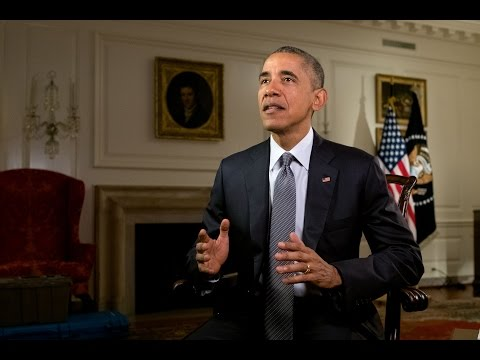

In [20]:
YOUTUBE_ID = '2AFpAATHXtc'


YouTubeVideo(YOUTUBE_ID)

In [21]:
!rm -rf *.wav
!youtube-dl --extract-audio --audio-format wav --output "test.%(ext)s" https://www.youtube.com/watch\?v\={YOUTUBE_ID}
!deepspeech --model deepspeech-0.6.1-models/output_graph.pbmm --lm deepspeech-0.6.1-models/lm.binary --trie deepspeech-0.6.1-models/trie --audio test.wav

[youtube] 2AFpAATHXtc: Downloading webpage
[youtube] 2AFpAATHXtc: Downloading video info webpage
[download] Destination: test.m4a
[download] 100% of 2.68MiB in 00:00
[ffmpeg] Correcting container in "test.m4a"
[ffmpeg] Destination: test.wav
Deleting original file test.m4a (pass -k to keep)
Loading model from file deepspeech-0.6.1-models/output_graph.pbmm
TensorFlow: v1.14.0-21-ge77504a
DeepSpeech: v0.6.1-0-g3df20fe
2020-02-19 18:10:31.981115: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-02-19 18:10:31.982226: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2020-02-19 18:10:31.986438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-02-19 18:10:31.986940: I tensorf

# see also..

* SpecAug
https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html

* VREW from VoyagerX
https://vrew.voyagerx.com/ko/



# Data Augmentation with Speech MNIST - specaug

In [2]:
!wget --no-check-certificate -qq -r 'https://docs.google.com/uc?export=download&id=1CFKZf97pTozo2DNPnDsMcY0SVPvN8mj-' -O recordings_npy.zip
!mkdir speech_mnist
!unzip -qq /content/recordings_npy.zip -d ./speech_mnist 

mkdir: cannot create directory ‘speech_mnist’: File exists
replace ./speech_mnist/0_jackson_0.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
# baseline 모델 설계
def pad(mel, max_length):
  if np.shape(mel)[1] >= max_length:
    return mel[:,:max_length]
  else :
    pad_length = max_length-np.shape(mel)[1]
    return np.concatenate((mel, np.zeros((128, pad_length))), axis=1)


def preprocessing(wav_path):
  X_temp = []
  Y = []
  sr = 8000
  n_fft = 512
  hop_length = 128
  classes = 10

  for item in wav_path:
    audio = np.load(item)
    melspectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length =hop_length)
    # mel_norm = melspectrogram/np.max(melspectrogram)
    # mel_log = np.log(mel_norm+1e-5)
    X_temp.append(melspectrogram)
    label = np.eye(classes)[(int)(item.split('/')[-1].split('_')[0])]
    Y.append(label)
  
  # max_length_padding
  all_length = [] 
  for item in X_temp:
    all_length.append(np.shape(item)[1])
  max_length = np.max(all_length)

  X = []
  for item in X_temp:
    X.append(pad(item, max_length))

  X = np.asarray(X)
  Y = np.asarray(Y)
  return X, Y


def build_model():
  model = Sequential()
  model.add(BatchNormalization(input_shape=(128,143)))
  model.add(Activation('relu'))
  model.add(Conv1D(64,3,padding='same',kernel_initializer='he_normal'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv1D(64,3,padding='same',kernel_initializer='he_normal'))
  model.add(pooling.MaxPooling1D(pool_size=2))
  model.add(pooling.MaxPooling1D(pool_size=2))
  model.add(pooling.AveragePooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  return model

def train(model, X, Y):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=777)
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  hist = model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=0, validation_split=0.1)
  return hist


def evaluate(model, X, Y):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=777)
  print(model.evaluate(X_test, Y_test))

In [4]:
import glob
import numpy as np 
import librosa
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, Input, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv1D, BatchNormalization,pooling
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint



wav_path = sorted(glob.glob('./speech_mnist/*.npy'))
X, Y = preprocessing(wav_path)
model = build_model()
hist = train(model, X, Y)
evaluate(model, X, Y)










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








200/200 [==============================] - 0s 443us/step
[1.2347359371185302, 0.555]


In [9]:
np.shape(X)

(2000, 128, 143)

In [0]:

def spec_aug(mel_spec):
  freq = np.shape(mel_spec)[0]
  time = np.shape(mel_spec)[1]
  f_frame = np.random.randint(0, 32)
  t_frame = np.random.randint(0,6)

  f_location = np.random.randint(0,freq-f_frame)
  t_location = np.random.randint(0,time-t_frame)

  for i in range(0,f_frame):
    mel_spec[f_location+i,:] = 0

  for i in range(0,t_frame):
    mel_spec[:,t_location+t_frame] = 0
  return mel_spec


def preprocessing_specaug(wav_path, specaug_iterations):
  X_temp = []
  Y = []
  sr = 8000
  n_fft = 512
  hop_length = 128
  classes = 10

  for item in wav_path:
    audio = np.load(item)
    melspectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length =hop_length)
    # mel_norm = melspectrogram/np.max(melspectrogram)
    # mel_log = np.log(mel_norm+1e-5)
    X_temp.append(melspectrogram)
    label = np.eye(classes)[(int)(item.split('/')[-1].split('_')[0])]
    Y.append(label)
    for iterations in range(specaug_iterations):
      X_temp.append(spec_aug(melspectrogram))
      Y.append(label)

 
  # max_length_padding
  all_length = [] 
  for item in X_temp:
    all_length.append(np.shape(item)[1])
  max_length = np.max(all_length)

  X = []
  for item in X_temp:
    X.append(pad(item, max_length))

  X = np.asarray(X)
  Y = np.asarray(Y)
  return X, Y

In [6]:
import glob
import numpy as np 
import librosa
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, Input, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv1D, BatchNormalization,pooling
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


wav_path = sorted(glob.glob('./speech_mnist/*.npy'))
X, Y = preprocessing_specaug(wav_path, 5)
model = build_model()
hist = train(model, X, Y)
evaluate(model, X, Y)

1200/1200 [==============================] - 0s 217us/step
[0.9645346577962239, 0.6708333333333333]


In [0]:
# how about pitch augmentation? crepe? pysptk? pyworld? librosa?

!wget --no-check-certificate -qq -r 'https://docs.google.com/uc?export=download&id=1vD12AFfbA8vrTHeXb1IKk4wKbZwWDARg' -O recordings.zip
!mkdir speech_mnist
!unzip -qq /content/recordings.zip -d ./speech_mnist 


def preprocessing_pitch_augment(wav_path, num):
  
  ''' your code here '''
  
  return X, Y


# Speech MNIST With Test Samples